In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Commented out IPython magic to ensure Python compatibility.
import os
import sys
import time
import glob
import random
import argparse
import pickle
import numpy as np
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import lfilter
import scipy.signal as signal
from sklearn.utils import shuffle, compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Add, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten,
    Conv2D, DepthwiseConv2D, MaxPooling2D,
    BatchNormalization, GlobalAveragePooling2D,
    Add
)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D,
    Dense, Dropout, Add, ReLU
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# %matplotlib inline

class DataSet2(object):

    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._cls = cls
        self._epochs_done = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_done(self):
        return self._epochs_done

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]

def read_train_sets2(train_path, classes, validation_size):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, img_names, cls = load_train2(train_path, classes)  # 2 calculating, 3 loading
    images, labels, img_names, cls = shuffle(images, labels, img_names, cls)

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_img_names = img_names[:validation_size]
    validation_cls = cls[:validation_size]

    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_img_names = img_names[validation_size:]
    train_cls = cls[validation_size:]
#     print('Training dataset shape:',len (train_images))
    data_sets.train = DataSet2(train_images, train_labels, train_img_names, train_cls)
    data_sets.valid = DataSet2(validation_images, validation_labels, validation_img_names, validation_cls)

    return data_sets

def load_train2(train_path, classes):
    samples = []
    labels = []
    sample_names = []
    cls = []

    for fields in classes:
        index = classes.index(fields)
        path = os.path.join(train_path, fields, '*.npy')
        files = glob.glob(path)
        for fl in files:
            iq_samples = np.load(fl)
            real = np.real(iq_samples)
            imag = np.imag(iq_samples)

            iq_samples = np.ravel(np.column_stack((real, imag)))

            multiple = False
            if multiple:
                iq_samples1 = iq_samples[:1568]
                iq_samples1 = iq_samples1.reshape(28, 28, 2)
                iq_samples2 = iq_samples[1568:3136]
                iq_samples2 = iq_samples2.reshape(28, 28, 2)
                iq_samples3 = iq_samples[3136:4704]
                iq_samples3 = iq_samples3.reshape(28, 28, 2)
                iq_samples4 = iq_samples[4704:6272]
                iq_samples4 = iq_samples4.reshape(28, 28, 2)
                samples.append(iq_samples1)
                samples.append(iq_samples2)
                samples.append(iq_samples3)
                samples.append(iq_samples4)

                flbase = os.path.basename(fl)
                label = np.zeros(len(classes))
                label[index] = 1.0

                labels.append(label)
                labels.append(label)
                labels.append(label)
                labels.append(label)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
            else:
                iq_samples = iq_samples[:1568]
                iq_samples = iq_samples.reshape(28, 28, 2)
                samples.append(iq_samples)

                label = np.zeros(len(classes))
                label[index] = 1.0
                labels.append(label)
                flbase = os.path.basename(fl)
                sample_names.append(flbase)
                cls.append(fields)

    samples = np.array(samples)
    labels = np.array(labels)
    sample_names = np.array(sample_names)
    cls = np.array(cls)
    return samples, labels, sample_names, cls

# Function to read the samples from _prediction_samples.dat files

def read_samples_sdr(freq):
    sdr = RtlSdr()
    sdr.sample_rate = sample_rate
    sdr.err_ppm = 56   # change it to yours
    sdr.gain = 'auto'

    f_offset = 250000  # shifted tune to avoid DC
    sdr.center_freq = freq - f_offset
    time.sleep(0.06)
    iq_samples = sdr.read_samples(1221376)
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples


def read_samples(freq):
    f_offset = 250000  # Shifted tune to avoid DC
    samp = np.fromfile(str(freq)+'_prediction_samples.dat',np.uint8)+np.int8(-127) # Adding a signed int8 to an unsigned one results in an int16 array
    x1 = samp[::2]/128 # Even samples are real(In-phase)
    x2 = samp[1::2]/128 # Odd samples are imaginary(Quadrature-phase)
    iq_samples = x1+x2*1j # Create the complex data samples
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # Shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples

########### Main Code #################################

############ Data for training the model #################
train_path ='/content/drive/MyDrive/Dataset_Deep_Radio/Dataset_Deep_Radio/training_data'
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))] # Gets classes from all the folders mentioned under training_data folder
print(classes)
# classes = ['BPSK','GMSK','QPSK']
num_classes = len(classes)
data = read_train_sets2(train_path, classes, validation_size=0.2) # Gets the data object using a class in dataset2.py

Xtrain = data.train.images
Ytrain = data.train.labels
Xtest = data.valid.images
Ytest = data.valid.labels

print('Training dataset shape:',Xtrain.shape)
print('Training dataset label:',Ytrain.shape)
print('Testing dataset shape:',Xtest.shape)
print('Testing dataset label:',Ytest.shape)

Mounted at /content/drive
['16QAM', '64QAM', 'BPSK', 'CPFSK', 'GFSK', 'GMSK', 'OTHER', 'QPSK']
Training dataset shape: (2400, 28, 28, 2)
Training dataset label: (2400, 8)
Testing dataset shape: (600, 28, 28, 2)
Testing dataset label: (600, 8)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D,
    Dense, Dropout, Add, ReLU
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


# -----------------------------
# Model definition
# -----------------------------
class EnhancedOptimizedCNN:
    def __init__(self, input_shape, num_classes, alpha):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.alpha = alpha
        self.model = None

    def _inverted_residual_block_v2(self, x, filters, strides, expand_ratio, alpha, dropout_rate):
        input_channels = int(x.shape[-1])
        expanded_channels = int(input_channels * expand_ratio * alpha)
        output_channels = int(filters * alpha)

        if expand_ratio != 1:
            x_expanded = Conv2D(expanded_channels, (1, 1), padding='same', use_bias=False)(x)
            x_expanded = BatchNormalization()(x_expanded)
            x_expanded = ReLU(max_value=6.0)(x_expanded)
            x_expanded = Dropout(dropout_rate)(x_expanded)
        else:
            x_expanded = x

        x_dw = DepthwiseConv2D((3, 3), strides=strides, padding='same', use_bias=False)(x_expanded)
        x_dw = BatchNormalization()(x_dw)
        x_dw = ReLU(max_value=6.0)(x_dw)

        x_proj = Conv2D(output_channels, (1, 1), padding='same', use_bias=False)(x_dw)
        x_proj = BatchNormalization()(x_proj)

        if strides == 1 and input_channels == output_channels:
            x_proj = Dropout(dropout_rate / 2)(x_proj)
            return Add()([x, x_proj])
        else:
            return x_proj

    def _build_enhanced_model(self, dropout_rates):
        inputs = Input(shape=self.input_shape)

        x = Conv2D(int(12 * self.alpha), (3, 3), strides=1, padding='same', use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = ReLU(max_value=6.0)(x)
        x = Dropout(dropout_rates[0])(x)

        x = self._inverted_residual_block_v2(x, 20, strides=2, expand_ratio=1,
                                             alpha=self.alpha, dropout_rate=dropout_rates[1])
        x = self._inverted_residual_block_v2(x, 24, strides=1, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[2])
        x = self._inverted_residual_block_v2(x, 48, strides=2, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[3])
        x = self._inverted_residual_block_v2(x, 64, strides=1, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[4])

        x = GlobalAveragePooling2D()(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(dropout_rates[5])(x)

        outputs = Dense(self.num_classes, activation='softmax')(x)
        return Model(inputs, outputs, name='EnhancedOptimizedCNN_AdamW')

    def create_model(self, dropout_rates):
        self.model = self._build_enhanced_model(dropout_rates)
        return self.model


# -----------------------------
# Augmentation
# -----------------------------
class AdvancedRFAugmentation:
    def __init__(self, snr_range, augmentation_factor):
        self.snr_range = snr_range
        self.augmentation_factor = augmentation_factor

    def add_awgn(self, signal, snr_db):
        snr_linear = 10.0 ** (snr_db / 10.0)
        if signal.shape[-1] == 2:
            signal_power = np.mean(signal[:, :, 0] ** 2 + signal[:, :, 1] ** 2)
        else:
            signal_power = np.mean(signal ** 2)
        noise_power = signal_power / snr_linear
        noise_std = np.sqrt(noise_power / 2)

        if np.random.random() > 0.8:
            white_noise = np.random.normal(0, noise_std, signal.shape)
            colored_noise = np.zeros_like(white_noise)
            for i in range(1, signal.shape[0]):
                colored_noise[i] = 0.7 * colored_noise[i - 1] + 0.3 * white_noise[i]
            noise = colored_noise
        else:
            noise = np.random.normal(0, noise_std, signal.shape)

        return (signal + noise).astype(np.float32)

    def add_frequency_selective_fading(self, signal):
        if signal.shape[-1] != 2:
            return signal
        if np.random.random() > 0.7:
            delay = np.random.randint(1, 4)
            amplitude = np.random.uniform(0.3, 0.7)
            delayed_signal = np.roll(signal, delay, axis=0) * amplitude
            return signal + delayed_signal
        return signal

    def add_phase_noise(self, signal, phase_std=0.15):
        if signal.shape[-1] != 2:
            return signal
        phase_noise = np.random.normal(0, phase_std, signal.shape[:2])
        for i in range(1, signal.shape[0]):
            phase_noise[i] = 0.9 * phase_noise[i - 1] + 0.1 * phase_noise[i]
        cos_noise = np.cos(phase_noise)
        sin_noise = np.sin(phase_noise)
        i_noisy = signal[:, :, 0] * cos_noise - signal[:, :, 1] * sin_noise
        q_noisy = signal[:, :, 0] * sin_noise + signal[:, :, 1] * cos_noise
        result = signal.copy()
        result[:, :, 0] = i_noisy
        result[:, :, 1] = q_noisy
        return result

    def augment_batch_enhanced(self, signals, labels):
        augmented_signals, augmented_labels = [], []
        for i in range(len(signals)):
            augmented_signals.append(signals[i])
            augmented_labels.append(labels[i])
            for _ in range(self.augmentation_factor):
                snr_db = np.random.uniform(self.snr_range[0], self.snr_range[1])
                augmented_signal = self.add_awgn(signals[i], snr_db)
                if np.random.random() > 0.6:
                    augmented_signal = self.add_frequency_selective_fading(augmented_signal)
                if np.random.random() > 0.7:
                    augmented_signal = self.add_phase_noise(augmented_signal)
                augmented_signals.append(augmented_signal)
                augmented_labels.append(labels[i])
        return np.array(augmented_signals), np.array(augmented_labels)


# -----------------------------
# Training pipeline
# -----------------------------
class ClassWeightedTrainingPipeline:
    def __init__(self, model, augmentor, classes):
        self.model = model
        self.augmentor = augmentor
        self.classes = classes
        self.history = None

    def compute_class_weights(self, y_train):
        y_train_labels = np.argmax(y_train, axis=1)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
        return dict(enumerate(class_weights))

    def create_enhanced_callbacks(self, checkpoint_path, patience_es, patience_lr, min_delta):
        return [
            EarlyStopping(monitor='val_loss', patience=patience_es, restore_best_weights=True, verbose=1, min_delta=min_delta),
            ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=patience_lr, min_lr=1e-8, verbose=1, cooldown=1),
            ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min')
        ]

    def train_enhanced_model(self, X_train, y_train, Xtest, Ytest,
                             epochs, batch_size, lr, weight_decay,
                             beta_1, beta_2,
                             patience_es, patience_lr, min_delta, checkpoint_path):

        X_train_aug, y_train_aug = self.augmentor.augment_batch_enhanced(X_train, y_train)
        class_weights = self.compute_class_weights(y_train_aug)
        callbacks = self.create_enhanced_callbacks(checkpoint_path, patience_es, patience_lr, min_delta)

        try:
            optimizer = tf.keras.optimizers.AdamW(
                learning_rate=lr,
                weight_decay=weight_decay,
                beta_1=beta_1,
                beta_2=beta_2
            )
        except Exception:
            import tensorflow_addons as tfa
            optimizer = tfa.optimizers.AdamW(
                learning_rate=lr,
                weight_decay=weight_decay,
                beta_1=beta_1,
                beta_2=beta_2,
            )

        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(
            X_train_aug, y_train_aug,
            validation_data=(Xtest, Ytest),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=1,
            shuffle=True
        )
        return self.history

In [ ]:
# ===== MODEL HYPERPARAMS =====
input_shape = (28, 28, 2)
num_classes = num_classes
alpha = 1
# dropout_rates = [0.1, 0.1, 0.15, 0.2, 0.25, 0.5]
dropout_rates = [0.05, 0.09, 0.14, 0.19, 0.20, 0.37]

# ===== AUGMENTATION HYPERPARAMS =====
snr_range = (5, 25)
augmentation_factor = 6

# ===== TRAINING HYPERPARAMS =====
epochs = 100
batch_size = 32
learning_rate = 1e-4
weight_decay = 2e-4
beta_1 = 0.86
beta_2 = 0.99

patience_es = 6
patience_lr = 3
min_delta = 5e-4
checkpoint_path = "enhanced_best_model.keras"

In [ ]:
# ===== MODEL CREATION =====
enhanced_cnn = EnhancedOptimizedCNN(input_shape=input_shape, num_classes=num_classes, alpha=alpha)
enhanced_model = enhanced_cnn.create_model(dropout_rates)
enhanced_model.summary()

# ===== AUGMENTOR =====
enhanced_augmentor = AdvancedRFAugmentation(snr_range=snr_range, augmentation_factor=augmentation_factor)

# ===== TRAINING PIPELINE =====
enhanced_pipeline = ClassWeightedTrainingPipeline(enhanced_model, enhanced_augmentor, classes)

Model: "EnhancedOptimizedCNN_AdamW"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 12)     │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 12)     │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 28, 28, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 28, 28, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_4              │ (None, 14, 14, 12)     │           108 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 12)     │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 14, 14, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 20)     │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 14, 14, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 40)     │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 14, 14, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 14, 14, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_5              │ (None, 14, 14, 40)     │           360 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 14, 14, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 14, 14, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 24)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 14, 14, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 48)     │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 14, 14, 48)     │           19

 Total params: 22,724 (88.77 KB)

 Trainable params: 21,628 (84.48 KB)

 Non-trainable params: 1,096 (4.28 KB)

=== Creating Models ===

=== Proposed (Ours) Summary ===


Model: "EnhancedOptimizedCNN_AdamW"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 12)     │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 28, 28, 12)     │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 28, 28, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 28, 28, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_12             │ (None, 14, 14, 12)     │           108 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 14, 14, 12)     │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 14, 14, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 14, 14, 20)     │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 14, 14, 20)     │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 14, 14, 40)     │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 14, 14, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 14, 14, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 14, 14, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_13             │ (None, 14, 14, 40)     │           360 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 14, 14, 40)     │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 14, 14, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 14, 14, 24)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 14, 14, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 14, 14, 48)     │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 14, 14, 48)     │           19

 Total params: 22,724 (88.77 KB)

 Trainable params: 21,628 (84.48 KB)

 Non-trainable params: 1,096 (4.28 KB)


=== Baseline [13] Summary ===


Model: "Baseline_Model_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 28, 28, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 28, 28, 128)    │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,800 (725.78 KB)

 Trainable params: 184,904 (722.28 KB)

 Non-trainable params: 896 (3.50 KB)


=== MobileNetV2 Summary ===


Model: "MobileNetV2_RF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 28, 28, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 3)      │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_32             │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,993 (9.24 MB)

 Trainable params: 2,388,881 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)


STARTING MODEL COMPARISON

=== Training Proposed (Ours) ===

=== Evaluating Proposed (Ours) ===


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Proposed (Ours) - Accuracy: 0.9367, F1-Weighted: 0.9362

=== Training Baseline [13] ===

=== Evaluating Baseline [13] ===
Baseline [13] - Accuracy: 0.9467, F1-Weighted: 0.9460

=== Training MobileNetV2 ===

=== Evaluating MobileNetV2 ===
MobileNetV2 - Accuracy: 0.1233, F1-Weighted: 0.0271

GENERATING COMPARISON RESULTS


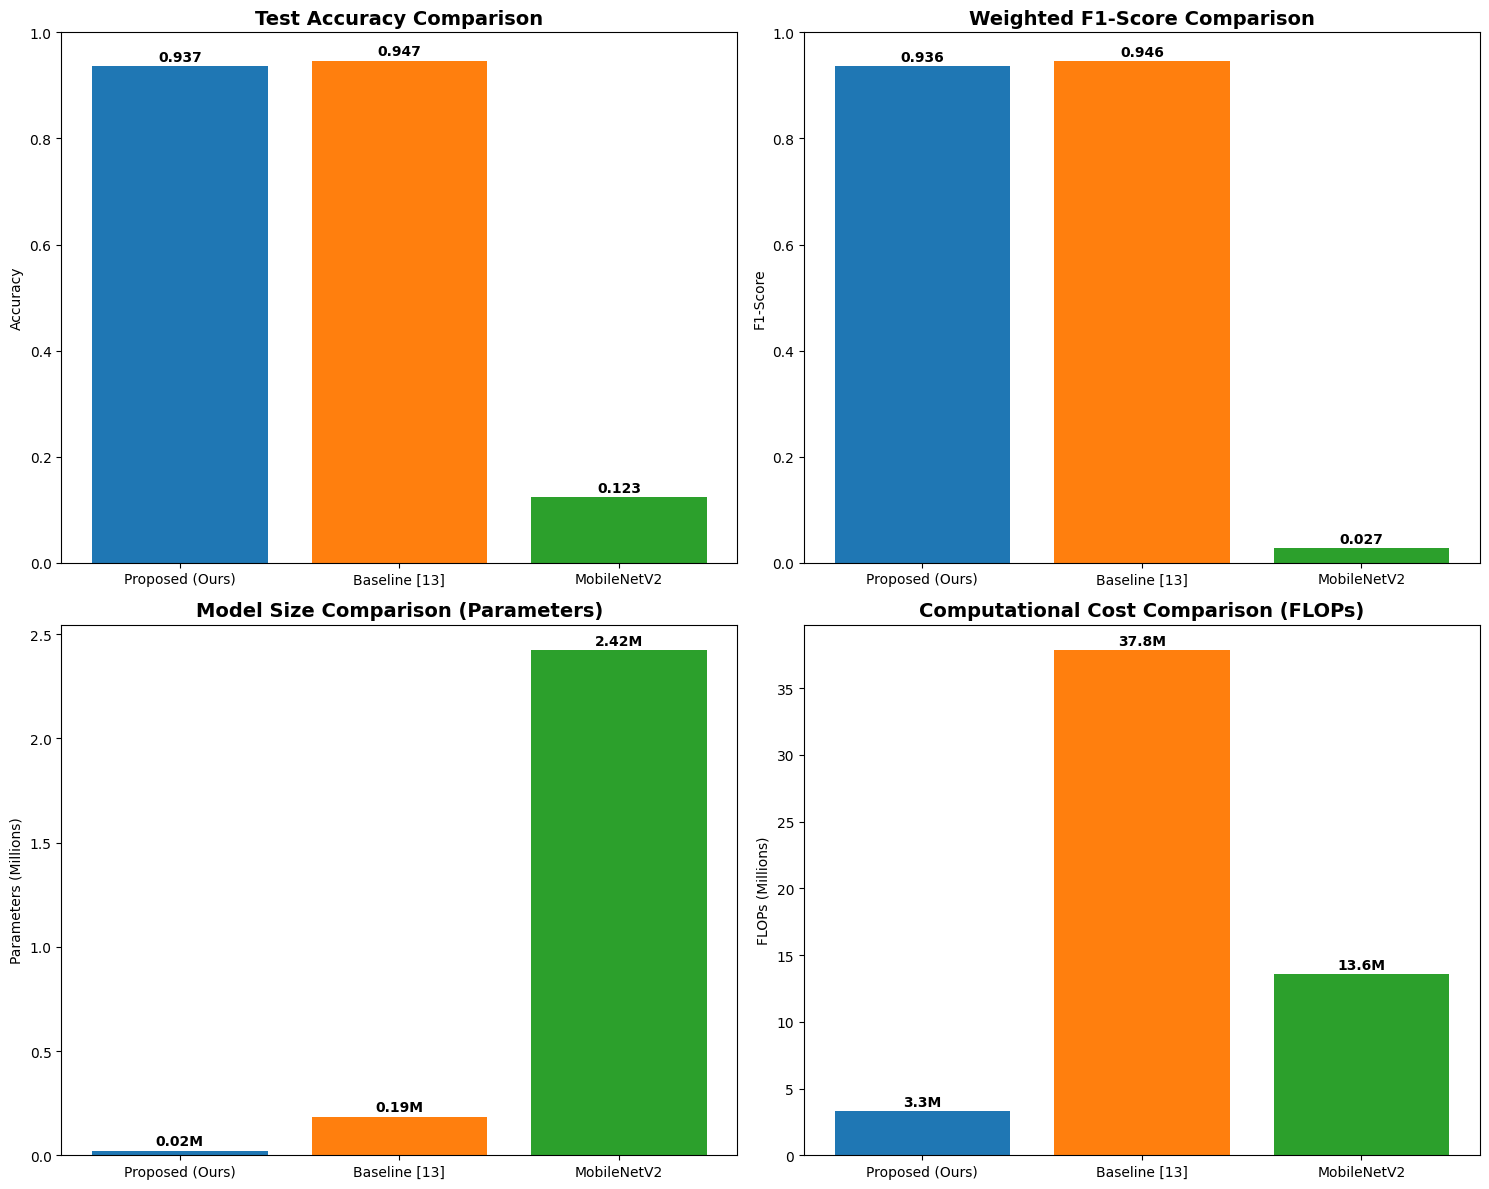

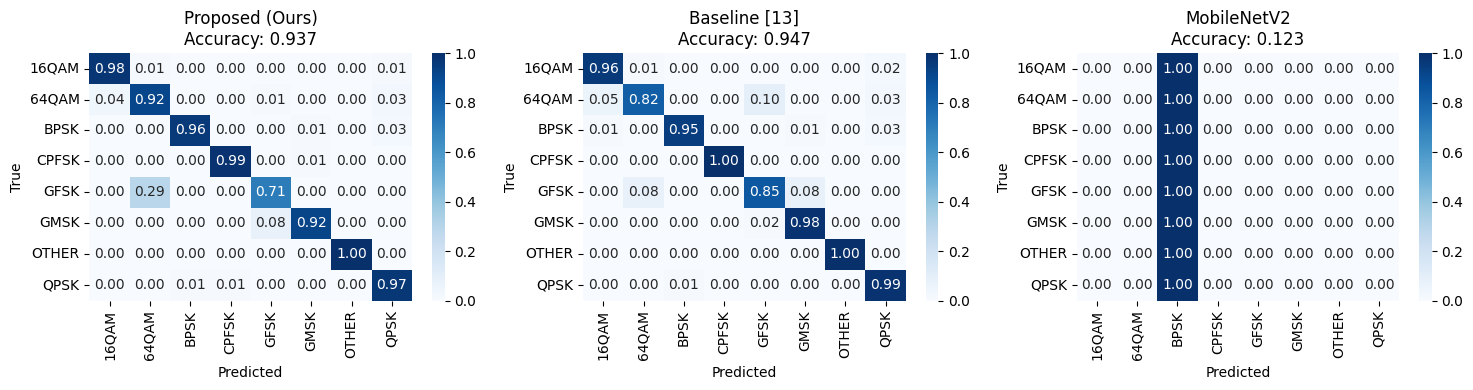

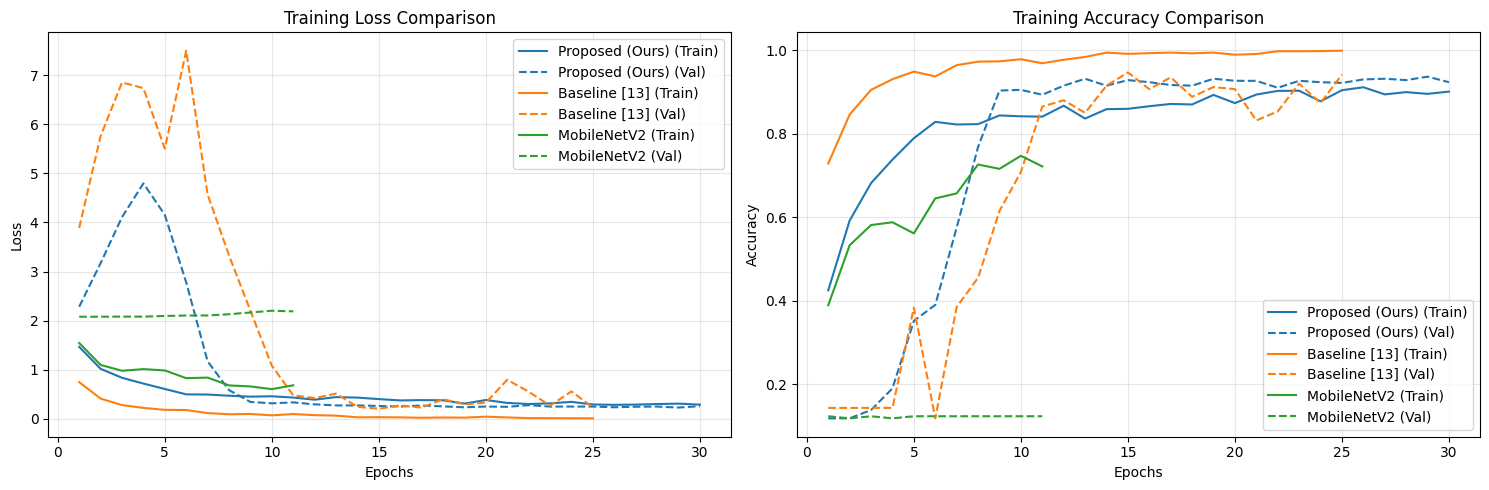


=== COMPREHENSIVE RESULTS TABLE ===
          Model Accuracy F1-Weighted F1-Macro Parameters (M) FLOPs (M)
Proposed (Ours)   0.9367      0.9362   0.9314           0.02       3.3
  Baseline [13]   0.9467      0.9460   0.9426           0.19      37.8
    MobileNetV2   0.1233      0.0271   0.0274           2.42      13.6

=== DETAILED CLASSIFICATION REPORTS ===

--- Proposed (Ours) ---
              precision    recall  f1-score   support

       16QAM     0.9639    0.9756    0.9697        82
       64QAM     0.7701    0.9178    0.8375        73
        BPSK     0.9861    0.9595    0.9726        74
       CPFSK     0.9881    0.9881    0.9881        84
        GFSK     0.8846    0.7077    0.7863        65
        GMSK     0.9677    0.9231    0.9449        65
       OTHER     1.0000    1.0000    1.0000        86
        QPSK     0.9324    0.9718    0.9517        71

    accuracy                         0.9367       600
   macro avg     0.9366    0.9304    0.9314       600
weighted avg     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import *
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

# =============================================
# MODEL DEFINITIONS
# =============================================

class BaselineModel:
    """Baseline Model [13] from your cited paper"""
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None

    def create_model(self):
        input_signal = Input(shape=self.input_shape)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_signal)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Dropout(0.1)(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dense(self.num_classes, activation='softmax')(x)

        self.model = Model(input_signal, x, name='Baseline_Model_13')
        return self.model

from tensorflow.keras.layers import Resizing

class MobileNetV2Adapter:
    """MobileNetV2 adapted for RF modulation classification"""
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None

    def create_model(self):
        input_layer = Input(shape=self.input_shape)

        # Convert 2-channel to 3-channel
        if self.input_shape[-1] == 2:
            x = Conv2D(3, (1, 1), padding='same')(input_layer)
        else:
            x = input_layer

        # Resize to 32x32 for MobileNetV2
        x = Resizing(32, 32)(x)

        # MobileNetV2 backbone
        base_model = MobileNetV2(
            input_shape=(32, 32, 3),
            include_top=False,
            weights=None
        )

        x = base_model(x)
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(self.num_classes, activation='softmax')(x)

        self.model = Model(input_layer, x, name='MobileNetV2_RF')
        return self.model

# =============================================
# FLOPS AND PARAMETER CALCULATION
# =============================================

def get_model_stats(model, input_shape):
    """Calculate FLOPs and parameters for a model"""
    # Parameters
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = total_params - trainable_params

    # FLOPs calculation
    concrete_func = tf.function(lambda x: model(x)).get_concrete_function(
        tf.TensorSpec([1] + list(input_shape), tf.float32)
    )

    try:
        opts = ProfileOptionBuilder.float_operation()
        flops = profile(concrete_func.graph, options=opts)
        total_flops = flops.total_float_ops
    except:
        # Fallback if profiler fails
        total_flops = 0

    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'non_trainable_params': non_trainable_params,
        'flops': total_flops
    }

# =============================================
# TRAINING AND EVALUATION PIPELINE
# =============================================

class ModelComparison:
    def __init__(self, models_dict, X_train, y_train, X_test, y_test, classes):
        self.models = models_dict
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.classes = classes
        self.results = {}

    def train_model(self, model_name, model, epochs=50, batch_size=32, verbose=0):
        """Train a single model"""
        print(f"\n=== Training {model_name} ===")

        # Compile model
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Add callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
        ]

        # Train
        history = model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_test, self.y_test),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )

        return history

    def evaluate_model(self, model_name, model):
        """Evaluate a single model"""
        print(f"\n=== Evaluating {model_name} ===")

        # Predictions
        y_pred_probs = model.predict(self.X_test, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(self.y_test, axis=1)

        # Metrics
        accuracy = accuracy_score(y_true, y_pred)
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        f1_macro = f1_score(y_true, y_pred, average='macro')

        # Model statistics
        stats = get_model_stats(model, self.X_train.shape[1:])

        # Store results
        self.results[model_name] = {
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'y_pred': y_pred,
            'y_true': y_true,
            'y_pred_probs': y_pred_probs,
            **stats
        }

        print(f"{model_name} - Accuracy: {accuracy:.4f}, F1-Weighted: {f1_weighted:.4f}")
        return self.results[model_name]

    def run_comparison(self, train_epochs=50):
        """Run complete comparison pipeline"""
        for model_name, model in self.models.items():
            # Train model
            history = self.train_model(model_name, model, epochs=train_epochs)

            # Evaluate model
            self.evaluate_model(model_name, model)

            # Store history
            self.results[model_name]['history'] = history

        return self.results

# =============================================
# VISUALIZATION FUNCTIONS
# =============================================

def plot_performance_comparison(results, save_path=None):
    """Plot performance metrics comparison"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    models = list(results.keys())

    # Accuracy comparison
    accuracies = [results[model]['accuracy'] for model in models]
    bars1 = ax1.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    for i, v in enumerate(accuracies):
        ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

    # F1-Score comparison
    f1_scores = [results[model]['f1_weighted'] for model in models]
    bars2 = ax2.bar(models, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax2.set_title('Weighted F1-Score Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('F1-Score')
    ax2.set_ylim(0, 1)
    for i, v in enumerate(f1_scores):
        ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

    # Parameter count comparison
    params = [results[model]['total_params']/1e6 for model in models]  # Convert to millions
    bars3 = ax3.bar(models, params, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax3.set_title('Model Size Comparison (Parameters)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Parameters (Millions)')
    for i, v in enumerate(params):
        ax3.text(i, v + max(params)*0.01, f'{v:.2f}M', ha='center', fontweight='bold')

    # FLOPs comparison
    flops = [results[model]['flops']/1e6 for model in models if results[model]['flops'] > 0]
    if len(flops) > 0:
        bars4 = ax4.bar(models[:len(flops)], flops, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        ax4.set_title('Computational Cost Comparison (FLOPs)', fontsize=14, fontweight='bold')
        ax4.set_ylabel('FLOPs (Millions)')
        for i, v in enumerate(flops):
            ax4.text(i, v + max(flops)*0.01, f'{v:.1f}M', ha='center', fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'FLOPs calculation\nnot available', ha='center', va='center',
                transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Computational Cost Comparison (FLOPs)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrices(results, classes, save_path=None):
    """Plot confusion matrices for all models"""
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    if n_models == 1:
        axes = [axes]

    for idx, (model_name, result) in enumerate(results.items()):
        cm = confusion_matrix(result['y_true'], result['y_pred'])
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=classes, yticklabels=classes, ax=axes[idx])
        axes[idx].set_title(f'{model_name}\nAccuracy: {result["accuracy"]:.3f}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def create_results_table(results):
    """Create a comprehensive results table"""
    table_data = []

    for model_name, result in results.items():
        table_data.append({
            'Model': model_name,
            'Accuracy': f"{result['accuracy']:.4f}",
            'F1-Weighted': f"{result['f1_weighted']:.4f}",
            'F1-Macro': f"{result['f1_macro']:.4f}",
            'Parameters (M)': f"{result['total_params']/1e6:.2f}",
            'FLOPs (M)': f"{result['flops']/1e6:.1f}" if result['flops'] > 0 else "N/A"
        })

    df = pd.DataFrame(table_data)
    return df

def plot_training_history(results, save_path=None):
    """Plot training history for all models"""
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for idx, (model_name, result) in enumerate(results.items()):
        if 'history' in result:
            history = result['history']
            epochs = range(1, len(history.history['loss']) + 1)

            # Loss plot
            ax1.plot(epochs, history.history['loss'],
                    color=colors[idx], linestyle='-', label=f'{model_name} (Train)')
            ax1.plot(epochs, history.history['val_loss'],
                    color=colors[idx], linestyle='--', label=f'{model_name} (Val)')

            # Accuracy plot
            ax2.plot(epochs, history.history['accuracy'],
                    color=colors[idx], linestyle='-', label=f'{model_name} (Train)')
            ax2.plot(epochs, history.history['val_accuracy'],
                    color=colors[idx], linestyle='--', label=f'{model_name} (Val)')

    ax1.set_title('Training Loss Comparison')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.set_title('Training Accuracy Comparison')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# =============================================
# MAIN COMPARISON EXECUTION
# =============================================

# Create all models
print("=== Creating Models ===")

# 1. Your proposed model (already defined)
enhanced_cnn = EnhancedOptimizedCNN(input_shape=input_shape, num_classes=num_classes, alpha=alpha)
proposed_model = enhanced_cnn.create_model(dropout_rates)

# 2. Baseline model [13]
baseline = BaselineModel(input_shape=input_shape, num_classes=num_classes)
baseline_model = baseline.create_model()

# 3. MobileNetV2 adapted
mobilenet_adapter = MobileNetV2Adapter(input_shape=input_shape, num_classes=num_classes)
mobilenet_model = mobilenet_adapter.create_model()

# Models dictionary
models_dict = {
    'Proposed (Ours)': proposed_model,
    'Baseline [13]': baseline_model,
    'MobileNetV2': mobilenet_model
}

# Print model summaries
for name, model in models_dict.items():
    print(f"\n=== {name} Summary ===")
    model.summary()

# =============================================
# RUN COMPARISON
# =============================================

print("\n" + "="*50)
print("STARTING MODEL COMPARISON")
print("="*50)

# Create comparison object
comparison = ModelComparison(
    models_dict=models_dict,
    X_train=Xtrain,
    y_train=Ytrain,
    X_test=Xtest,
    y_test=Ytest,
    classes=classes
)

# Run comparison (this will train and evaluate all models)
results = comparison.run_comparison(train_epochs=30)  # Adjust epochs as needed

# =============================================
# GENERATE ALL PLOTS AND TABLES
# =============================================

print("\n" + "="*50)
print("GENERATING COMPARISON RESULTS")
print("="*50)

# 1. Performance comparison plot
plot_performance_comparison(results, save_path='performance_comparison.png')

# 2. Confusion matrices
plot_confusion_matrices(results, classes, save_path='confusion_matrices.png')

# 3. Training history
plot_training_history(results, save_path='training_history.png')

# 4. Results table
results_table = create_results_table(results)
print("\n=== COMPREHENSIVE RESULTS TABLE ===")
print(results_table.to_string(index=False))

# 5. Save results table as CSV
results_table.to_csv('model_comparison_results.csv', index=False)

# 6. Detailed classification reports
print("\n=== DETAILED CLASSIFICATION REPORTS ===")
for model_name, result in results.items():
    print(f"\n--- {model_name} ---")
    report = classification_report(result['y_true'], result['y_pred'],
                                 target_names=classes, digits=4)
    print(report)

print("\n" + "="*50)
print("COMPARISON COMPLETE!")
print("Files saved: performance_comparison.png, confusion_matrices.png, training_history.png, model_comparison_results.csv")
print("="*50)

Training Baseline (70/30)...
Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.5315 - loss: 1.2669 - val_accuracy: 0.1278 - val_loss: 3.1517
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8409 - loss: 0.4395 - val_accuracy: 0.1278 - val_loss: 5.2734
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8975 - loss: 0.3093 - val_accuracy: 0.1278 - val_loss: 6.5311
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9232 - loss: 0.2447 - val_accuracy: 0.1278 - val_loss: 8.7602
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9293 - loss: 0.2145 - val_accuracy: 0.1589 - val_loss: 7.1350
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9090 - loss: 0.2473 - val_accuracy: 0.1278 - val_loss: 7.5300
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9297 - loss: 0.2129 - val_accuracy: 0.2567 - val_loss: 5.1930
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9442 - loss: 0.

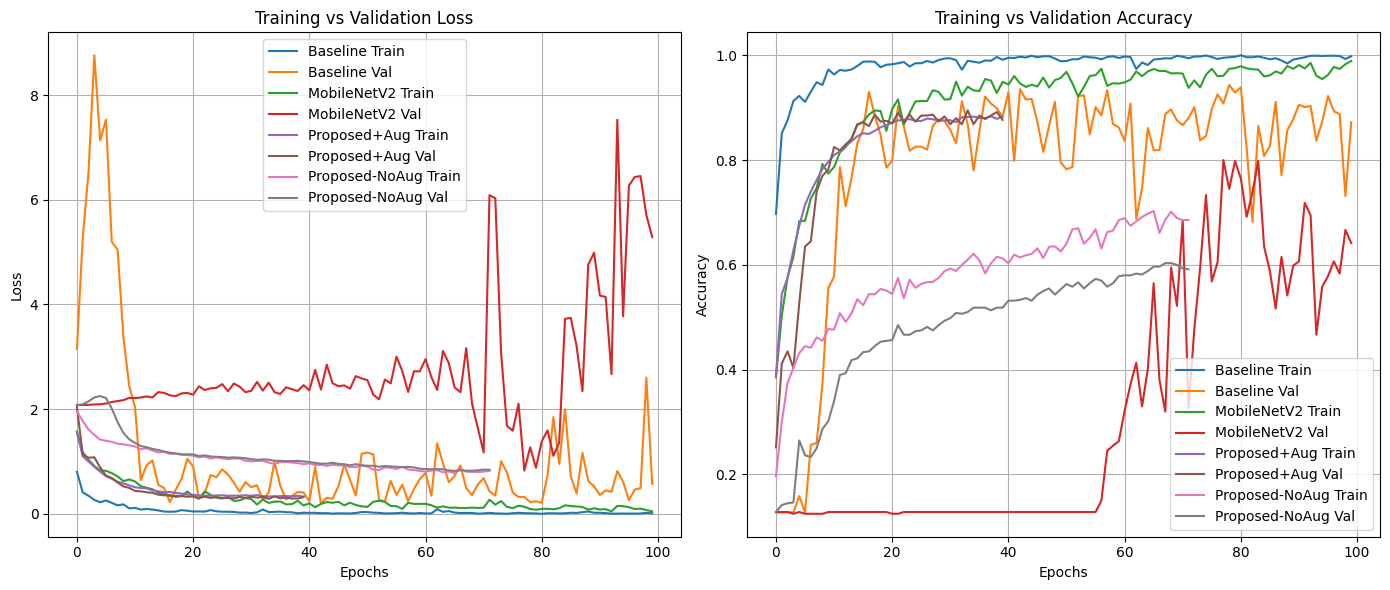

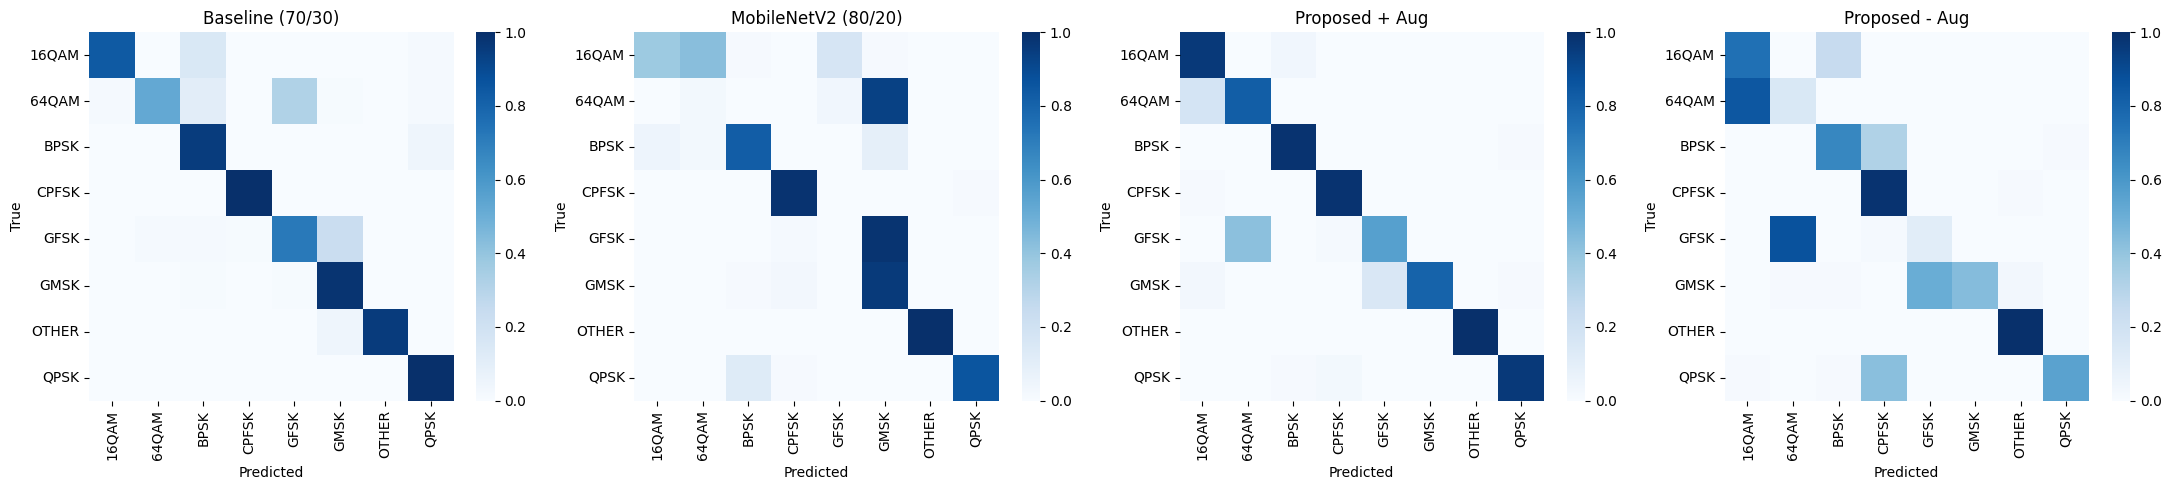

In [ ]:
# ==============================
# Mount Drive and Imports
# ==============================
# from google.colab import drive
# drive.mount('/content/drive')

import os, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils import shuffle, compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# ==============================
# Dataset Loader
# ==============================
class DataSet2(object):
    def __init__(self, images, labels):
        self._images = images
        self._labels = labels
        self._num_examples = images.shape[0]

    @property
    def images(self): return self._images
    @property
    def labels(self): return self._labels
    @property
    def num_examples(self): return self._num_examples

def load_train2(train_path, classes):
    samples, labels = [], []
    for idx, cls in enumerate(classes):
        path = os.path.join(train_path, cls, '*.npy')
        files = glob.glob(path)
        for fl in files:
            iq_samples = np.load(fl)
            real, imag = np.real(iq_samples), np.imag(iq_samples)
            iq_samples = np.ravel(np.column_stack((real, imag)))
            iq_samples = iq_samples[:1568].reshape(28, 28, 2)
            samples.append(iq_samples)
            label = np.zeros(len(classes)); label[idx] = 1.0
            labels.append(label)
    return np.array(samples), np.array(labels)

def read_train_sets2(train_path, classes, validation_size):
    class DataSets: pass
    data_sets = DataSets()
    images, labels = load_train2(train_path, classes)
    images, labels = shuffle(images, labels)
    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])
    val_images, val_labels = images[:validation_size], labels[:validation_size]
    train_images, train_labels = images[validation_size:], labels[validation_size:]
    data_sets.train = DataSet2(train_images, train_labels)
    data_sets.valid = DataSet2(val_images, val_labels)
    return data_sets

# ==============================
# Models
# ==============================
class BaselineModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape; self.num_classes = num_classes
    def create_model(self):
        inp = Input(shape=self.input_shape)
        x = Conv2D(128, (3,3), activation='relu', padding='same')(inp); x = BatchNormalization()(x)
        x = MaxPooling2D((2,2), padding='same')(x); x = Dropout(0.1)(x)
        for _ in range(3):
            x = Conv2D(64, (3,3), activation='relu', padding='same')(x); x = BatchNormalization()(x)
            x = MaxPooling2D((2,2), padding='same')(x)
        x = Flatten()(x); x = Dense(128, activation='relu')(x); x = BatchNormalization()(x)
        out = Dense(self.num_classes, activation='softmax')(x)
        return Model(inp, out, name="Baseline_Model")

class EnhancedOptimizedCNN:
    def __init__(self, input_shape, num_classes, alpha=1.0):
        self.input_shape = input_shape; self.num_classes = num_classes; self.alpha = alpha
    def _inverted_residual_block_v2(self, x, filters, strides, expand_ratio, alpha, dropout_rate):
        input_channels = int(x.shape[-1])
        expanded_channels = int(input_channels * expand_ratio * alpha)
        output_channels = int(filters * alpha)
        if expand_ratio != 1:
            x_exp = Conv2D(expanded_channels, (1,1), padding='same', use_bias=False)(x)
            x_exp = BatchNormalization()(x_exp); x_exp = ReLU(max_value=6.0)(x_exp); x_exp = Dropout(dropout_rate)(x_exp)
        else: x_exp = x
        x_dw = DepthwiseConv2D((3,3), strides=strides, padding='same', use_bias=False)(x_exp)
        x_dw = BatchNormalization()(x_dw); x_dw = ReLU(max_value=6.0)(x_dw)
        x_proj = Conv2D(output_channels, (1,1), padding='same', use_bias=False)(x_dw)
        x_proj = BatchNormalization()(x_proj)
        if strides==1 and input_channels==output_channels:
            x_proj = Dropout(dropout_rate/2)(x_proj); return Add()([x, x_proj])
        else: return x_proj
    def create_model(self, dropout_rates):
        inp = Input(shape=self.input_shape)
        x = Conv2D(int(12*self.alpha), (3,3), strides=1, padding='same', use_bias=False)(inp)
        x = BatchNormalization()(x); x = ReLU(max_value=6.0)(x); x = Dropout(dropout_rates[0])(x)
        x = self._inverted_residual_block_v2(x,20,2,1,self.alpha,dropout_rates[1])
        x = self._inverted_residual_block_v2(x,24,1,2,self.alpha,dropout_rates[2])
        x = self._inverted_residual_block_v2(x,48,2,2,self.alpha,dropout_rates[3])
        x = self._inverted_residual_block_v2(x,64,1,2,self.alpha,dropout_rates[4])
        x = GlobalAveragePooling2D()(x); x = Dense(32, activation='relu')(x); x = Dropout(dropout_rates[5])(x)
        out = Dense(self.num_classes, activation='softmax')(x)
        return Model(inp, out, name="EnhancedOptimizedCNN")

class MobileNetV2Adapter:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape; self.num_classes = num_classes
    def create_model(self):
        inp = Input(shape=self.input_shape)
        # Convert 2-channel to 3-channel
        if self.input_shape[-1] == 2:
            x = Conv2D(3, (1,1), padding='same')(inp)
        else: x = inp
        # Resize to 32x32
        x = Resizing(32,32)(x)
        base = MobileNetV2(input_shape=(32,32,3), include_top=False, weights=None)
        x = base(x); x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x); x = Dropout(0.2)(x)
        out = Dense(self.num_classes, activation='softmax')(x)
        return Model(inp, out, name="MobileNetV2_RF")

# ==============================
# Augmentation
# ==============================
class AdvancedRFAugmentation:
    def __init__(self, snr_range, augmentation_factor):
        self.snr_range = snr_range; self.augmentation_factor = augmentation_factor
    def add_awgn(self, signal, snr_db):
        snr_linear = 10.0**(snr_db/10.0)
        signal_power = np.mean(signal[:,:,0]**2 + signal[:,:,1]**2)
        noise_power = signal_power/snr_linear; noise_std = np.sqrt(noise_power/2)
        noise = np.random.normal(0, noise_std, signal.shape)
        return (signal+noise).astype(np.float32)
    def augment_batch_enhanced(self, signals, labels):
        aug_sigs, aug_labels = [], []
        for i in range(len(signals)):
            aug_sigs.append(signals[i]); aug_labels.append(labels[i])
            for _ in range(self.augmentation_factor):
                snr_db = np.random.uniform(self.snr_range[0], self.snr_range[1])
                aug_sigs.append(self.add_awgn(signals[i], snr_db)); aug_labels.append(labels[i])
        return np.array(aug_sigs), np.array(aug_labels)

# ==============================
# Training Pipeline
# ==============================
class ClassWeightedTrainingPipeline:
    def __init__(self, model, augmentor, classes, use_augmentation=True):
        self.model = model; self.augmentor = augmentor; self.classes = classes
        self.use_augmentation = use_augmentation; self.history=None
    def compute_class_weights(self, y_train):
        y_train_labels = np.argmax(y_train, axis=1)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
        return dict(enumerate(class_weights))
    def train_model(self, X_train, y_train, Xtest, Ytest,
                    epochs, batch_size, lr, weight_decay,
                    beta_1, beta_2, patience_es, patience_lr, min_delta):
        if self.use_augmentation: X_train_aug, y_train_aug = self.augmentor.augment_batch_enhanced(X_train, y_train)
        else: X_train_aug, y_train_aug = X_train, y_train
        class_weights = self.compute_class_weights(y_train_aug)
        callbacks = [EarlyStopping(monitor='val_loss', patience=patience_es, restore_best_weights=True, min_delta=min_delta),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=patience_lr, min_lr=1e-8)]
        optimizer = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay, beta_1=beta_1, beta_2=beta_2)
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(X_train_aug, y_train_aug, validation_data=(Xtest,Ytest),
                                      epochs=epochs, batch_size=batch_size, class_weight=class_weights,
                                      callbacks=callbacks, verbose=1, shuffle=True)
        return self.history

# ==============================
# Main Execution
# ==============================
train_path = '/content/drive/MyDrive/Dataset_Deep_Radio/Dataset_Deep_Radio/training_data'
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
num_classes = len(classes)

# Baseline 70/30 split
data_base = read_train_sets2(train_path, classes, validation_size=0.3)
Xtrain_base, Ytrain_base, Xtest_base, Ytest_base = data_base.train.images, data_base.train.labels, data_base.valid.images, data_base.valid.labels

# Proposed & MobileNetV2 80/20 split
data = read_train_sets2(train_path, classes, validation_size=0.2)
Xtrain, Ytrain, Xtest, Ytest = data.train.images, data.train.labels, data.valid.images, data.valid.labels

# Hyperparams
input_shape=(28,28,2); alpha=1
dropout_rates=[0.05,0.09,0.14,0.19,0.20,0.37]
snr_range=(5,25); augmentation_factor=6
epochs=100; batch_size=32; lr=1e-4; weight_decay=2e-4; beta_1=0.86; beta_2=0.99
patience_es=6; patience_lr=3; min_delta=5e-4

# Models
baseline = BaselineModel(input_shape, num_classes).create_model()
mobilenet = MobileNetV2Adapter(input_shape, num_classes).create_model()
enhanced_model_aug = EnhancedOptimizedCNN(input_shape, num_classes, alpha).create_model(dropout_rates)
enhanced_model_noaug = EnhancedOptimizedCNN(input_shape, num_classes, alpha).create_model(dropout_rates)

# Augmentor
augmentor = AdvancedRFAugmentation(snr_range, augmentation_factor)

# Training
print("Training Baseline (70/30)...")
baseline.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history_base = baseline.fit(Xtrain_base, Ytrain_base, validation_data=(Xtest_base,Ytest_base),
                            epochs=epochs, batch_size=batch_size, verbose=1)

print("Training MobileNetV2 (80/20)...")
mobilenet.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history_mobilenet = mobilenet.fit(Xtrain, Ytrain, validation_data=(Xtest,Ytest),
                                  epochs=epochs, batch_size=batch_size, verbose=1)

print("Training Proposed + Augmentation...")
pipeline_aug = ClassWeightedTrainingPipeline(enhanced_model_aug, augmentor, classes, use_augmentation=True)
history_aug = pipeline_aug.train_model(Xtrain,Ytrain,Xtest,Ytest,epochs,batch_size,lr,weight_decay,
                                       beta_1,beta_2,patience_es,patience_lr,min_delta)

print("Training Proposed - Augmentation...")
pipeline_noaug = ClassWeightedTrainingPipeline(enhanced_model_noaug, augmentor, classes, use_augmentation=False)
history_noaug = pipeline_noaug.train_model(Xtrain,Ytrain,Xtest,Ytest,epochs,batch_size,lr,weight_decay,
                                           beta_1,beta_2,patience_es,patience_lr,min_delta)

# ==============================
# Evaluation
# ==============================
def evaluate_model(model, Xtest, Ytest, name):
    y_pred_probs = model.predict(Xtest)
    y_pred = np.argmax(y_pred_probs, axis=1); y_true = np.argmax(Ytest, axis=1)
    acc = accuracy_score(y_true, y_pred); f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"{name} - Accuracy: {acc:.4f}, Weighted F1: {f1:.4f}")
    return acc, f1, confusion_matrix(y_true, y_pred)

acc_b,f1_b,cm_b = evaluate_model(baseline,Xtest_base,Ytest_base,"Baseline (70/30)")
acc_m,f1_m,cm_m = evaluate_model(mobilenet,Xtest,Ytest,"MobileNetV2 (80/20)")
acc_aug,f1_aug,cm_aug = evaluate_model(pipeline_aug.model,Xtest,Ytest,"Proposed + Aug")
acc_noaug,f1_noaug,cm_noaug = evaluate_model(pipeline_noaug.model,Xtest,Ytest,"Proposed - Aug")

# ==============================
# Training Curves
# ==============================
plt.figure(figsize=(14,6))

# Loss
plt.subplot(1,2,1)
plt.plot(history_base.history['loss'], label='Baseline Train')
plt.plot(history_base.history['val_loss'], label='Baseline Val')
plt.plot(history_mobilenet.history['loss'], label='MobileNetV2 Train')
plt.plot(history_mobilenet.history['val_loss'], label='MobileNetV2 Val')
plt.plot(history_aug.history['loss'], label='Proposed+Aug Train')
plt.plot(history_aug.history['val_loss'], label='Proposed+Aug Val')
plt.plot(history_noaug.history['loss'], label='Proposed-NoAug Train')
plt.plot(history_noaug.history['val_loss'], label='Proposed-NoAug Val')
plt.title("Training vs Validation Loss"); plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_base.history['accuracy'], label='Baseline Train')
plt.plot(history_base.history['val_accuracy'], label='Baseline Val')
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2 Train')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2 Val')
plt.plot(history_aug.history['accuracy'], label='Proposed+Aug Train')
plt.plot(history_aug.history['val_accuracy'], label='Proposed+Aug Val')
plt.plot(history_noaug.history['accuracy'], label='Proposed-NoAug Train')
plt.plot(history_noaug.history['val_accuracy'], label='Proposed-NoAug Val')
plt.title("Training vs Validation Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)


plt.tight_layout(); plt.show()

# ==============================
# Confusion Matrices
# ==============================
fig, axes = plt.subplots(1,4,figsize=(22,5))
for ax,cm,title in zip(axes,[cm_b,cm_m,cm_aug,cm_noaug],
                       ["Baseline (70/30)","MobileNetV2 (80/20)","Proposed + Aug","Proposed - Aug"]):
    cmn = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    sns.heatmap(cmn,annot=False,cmap="Blues",ax=ax,xticklabels=classes,yticklabels=classes)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()